# Assignment 1B - Question 2
## Person Re-Identification

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from scipy.io import loadmat

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.preprocessing.image import Iterator

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

import cv2
import os
import glob
import random

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Load data

Uses opencv's cv2.imread function on all files in a directory to load into a numpy array

In [2]:
train = []
gnd = []
files = glob.glob('Data/Q2/Q2/Q2/Training/*.jpg')
for myfile in files:
    image = cv2.imread(myfile, 0)
    gnd.append(myfile[23:27])
    train.append(image)

train = np.array(train)
gnd = np.array(gnd)

print('Training shape: ', train.shape)
print('Training gnd: ', gnd[1:10])

Training shape:  (5933, 128, 64)
Training gnd:  ['0001' '0001' '0001' '0001' '0001' '0001' '0001' '0001' '0001']


In [3]:
test_gal = []
test_gnd = []
files = glob.glob('Data/Q2/Q2/Q2/Testing/Gallery/*.jpg')
for myfile in files:
    image = cv2.imread(myfile, 0)
    test_gnd.append(myfile[30:34])
    test_gal.append(image)

test_gal = np.array(test_gal)

print('Training shape: ', test_gal.shape)

Training shape:  (301, 128, 64)


In [4]:
test_pro = []
files = glob.glob('Data/Q2/Q2/Q2/Testing/Probe/*.jpg')
for myfile in files:
    image = cv2.imread(myfile, 0)
    test_pro.append(image)

test_pro = np.array(test_pro)

print('Training shape: ', test_pro.shape)

Training shape:  (301, 128, 64)


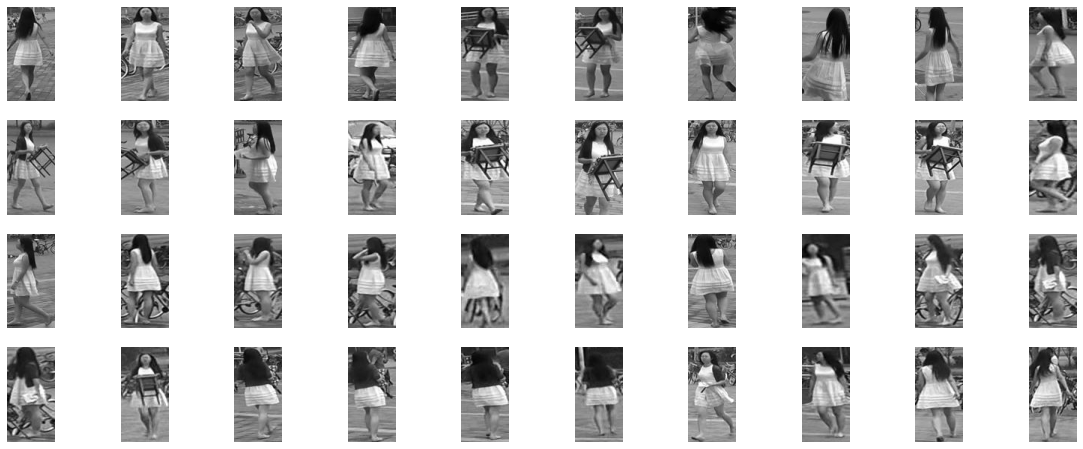

In [5]:
train_fea = np.reshape(train.transpose(), (64, 128, 1, len(train)))
fig = plt.figure(figsize=[20, 8])
for i in range(40):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea[:,:,0,i].transpose(), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()

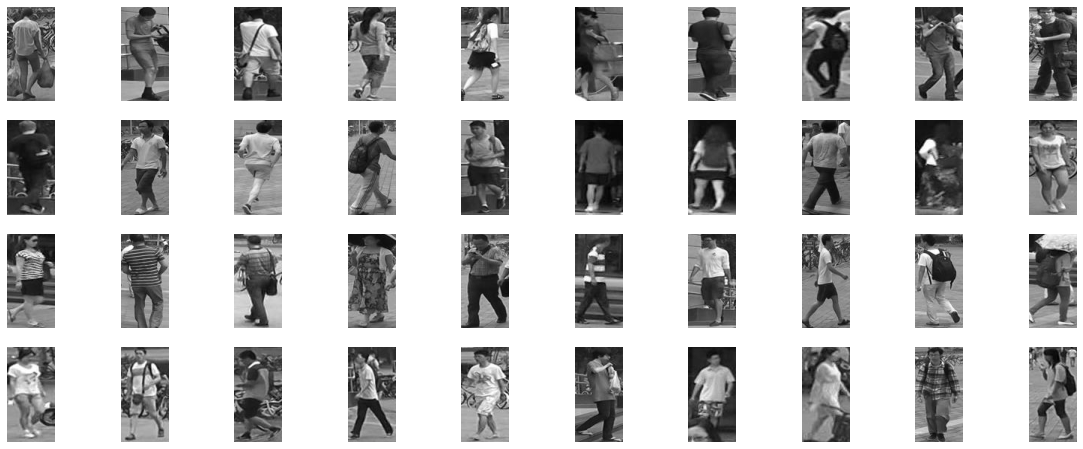

In [6]:
test_fea = np.reshape(test_gal.transpose(), (64, 128, 1, len(test_gal)))
fig = plt.figure(figsize=[20, 8])
for i in range(40):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(test_fea[:,:,0,i].transpose(), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()

In [7]:
print(test_gal.shape)

(301, 128, 64)


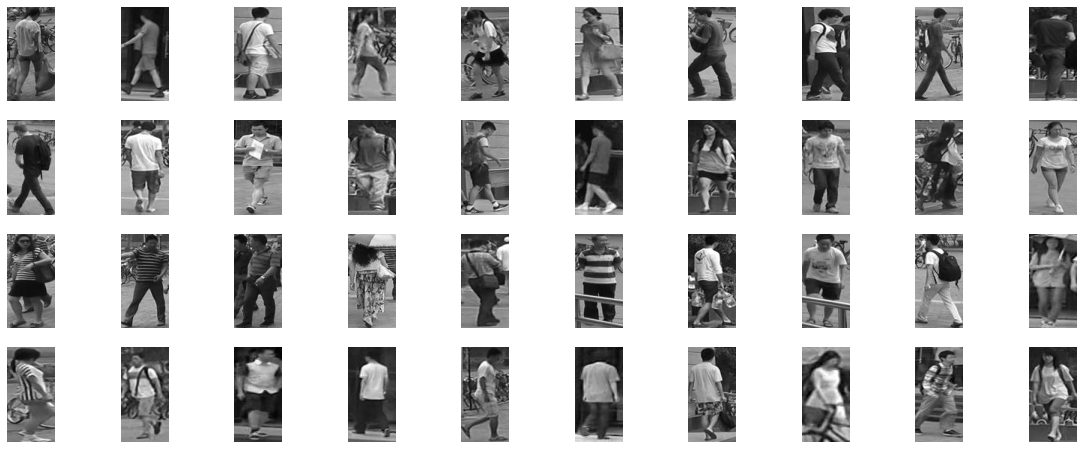

In [8]:
test_pro = np.reshape(test_pro.transpose(), (64, 128, 1, len(test_pro)))
fig = plt.figure(figsize=[20, 8])
for i in range(40):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(test_pro[:,:,0,i].transpose(), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()

### PCA

Code taken from Week 6 Example 5 Eigenfaces

In [9]:
train_fea = train
train_gnd = gnd
print(np.shape(train_fea))
print(np.shape(test_fea))

(5933, 128, 64)
(64, 128, 1, 301)


(8192, 1)


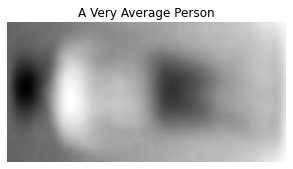

In [10]:
meanperson = np.reshape(np.mean(train_fea, axis=0), (-1, 1));
print(meanperson.shape)
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(1, 1, 1)
meanperson_im = np.reshape(meanperson, (128, 64))    
ax.imshow(meanperson_im.transpose(), cmap=plt.get_cmap('gray'))
ax.set_axis_off()
ax.set_title('A Very Average Person');

In [11]:
nsamples, nx, ny = train_fea.shape
d2_train_dataset = train_fea.reshape((nsamples,nx*ny))

pca = decomposition.PCA()
pca.fit(d2_train_dataset)
transformed = pca.transform(d2_train_dataset)

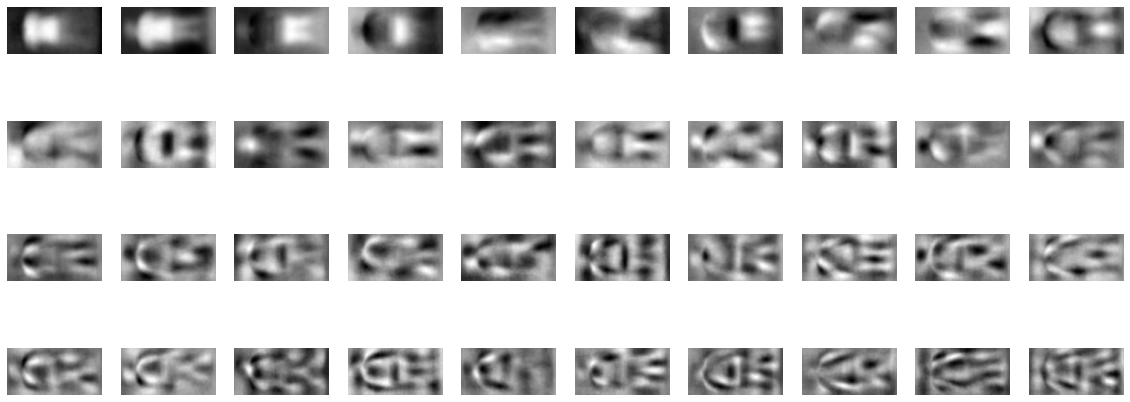

In [12]:
fig = plt.figure(figsize=[20, 8])
for i in range(40):
    ax = fig.add_subplot(4, 10, i + 1)
    pc = np.reshape(pca.components_[i,:], (128, 64))        
    ax.imshow(pc.transpose(), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()

Text(0.5, 0, 'Number of Components')

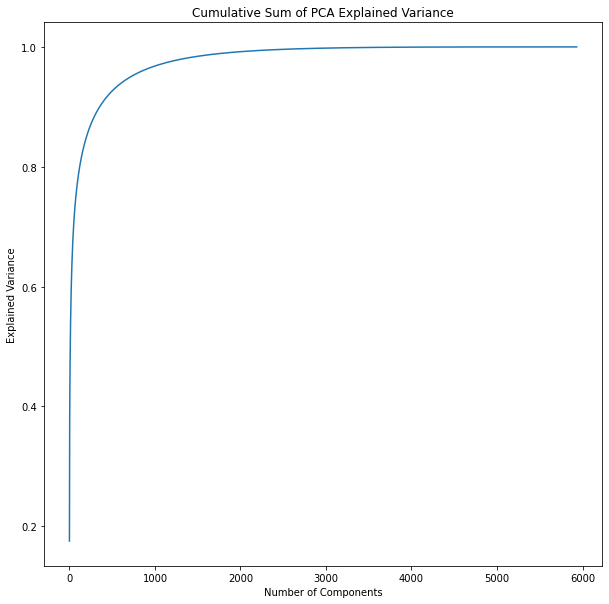

In [13]:
cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
ax.plot(cumulative_sum)
ax.set_title('Cumulative Sum of PCA Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Components')

In [14]:
top90 = np.where(cumulative_sum > 0.90)[0][0]
print('90% in ' + '%d' % (top90+1) + ' components')
top95 = np.where(cumulative_sum > 0.95)[0][0]
print('95% in ' + '%d' % (top95+1) + ' components')
top99 = np.where(cumulative_sum > 0.99)[0][0]
print('99% in ' + '%d' % (top99+1) + ' components')

90% in 355 components
95% in 715 components
99% in 1832 components


In [15]:
print(train_fea.shape)

(5933, 128, 64)


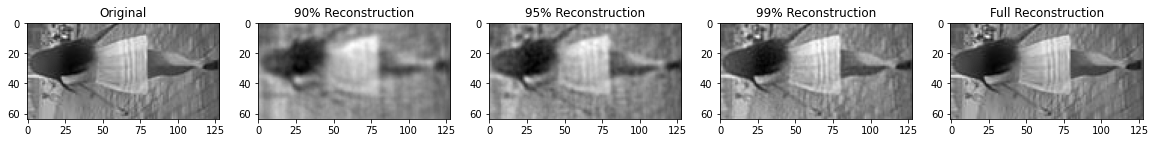

In [16]:
fig = plt.figure(figsize=[20, 5])
ax = fig.add_subplot(1, 5, 1)
ax.imshow(np.reshape(d2_train_dataset[0,:] - pca.mean_, (128, 64)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('Original');

ax = fig.add_subplot(1, 5, 2)
ax.imshow(np.reshape(pca.components_[0:top90,:].transpose().dot(np.reshape(transformed[0,0:top90], (-1, 1))), (128, 64)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('90% Reconstruction');

ax = fig.add_subplot(1, 5, 3)
ax.imshow(np.reshape(pca.components_[0:top95,:].transpose().dot(np.reshape(transformed[0,0:top95], (-1, 1))), (128, 64)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('95% Reconstruction');

ax = fig.add_subplot(1, 5, 4)
ax.imshow(np.reshape(pca.components_[0:top99,:].transpose().dot(np.reshape(transformed[0,0:top99], (-1, 1))), (128, 64)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('99% Reconstruction');

ax = fig.add_subplot(1, 5, 5)
ax.imshow(np.reshape(pca.components_[:,:].transpose().dot(np.reshape(transformed[0,:], (-1, 1))), (128, 64)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('Full Reconstruction');

In [17]:
transformed_train_90 = transformed[:, 0:top90]

transformed_test = pca.transform(d2_train_dataset)
transformed_test_90 = transformed_test[:, 0:top90]

distance = np.sqrt(np.sum((transformed_train_90 - transformed_test_90[0,:])**2, axis=1))

index_min = np.argmin(distance)

print(train_gnd[index_min])
print(test_gnd[0])

0001
1200


### Deep Learning Model - Siamese

Week 7 example 1

In [18]:
def GetSiameseData(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def PairGenerator(imgs, labels, batch_size):
    while True:
        [image_a, image_b], label = GetSiameseData(imgs, labels, batch_size)
        yield [image_a, image_b], label

In [19]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [20]:
embedding_size = 32
dummy_input = keras.Input((128, 64, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')
base_network.summary()

Model: "SiameseBranch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 64, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 64, 8)        80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 64, 8)        584       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 64, 8)        32        
_________________________________________________________________
activation (Activation)      (None, 128, 64, 8)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 128, 64, 8)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 32, 8)       

In [21]:
input_a = keras.Input((128, 64, 1), name='InputA')
input_b = keras.Input((128, 64, 1), name='InputB')

embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

In [22]:
combined = layers.concatenate([embedding_a, embedding_b])
combined = layers.Dense(128, activation='relu')(combined)
output = layers.Dense(1, activation='sigmoid')(combined)

siamese_network = keras.Model([input_a, input_b], output, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputA (InputLayer)             [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
InputB (InputLayer)             [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
SiameseBranch (Functional)      (None, 32)           4222072     InputA[0][0]                     
                                                                 InputB[0][0]                     
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 64)           0           SiameseBranch[0][0] 

In [23]:
siamese_network.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

In [24]:
test_gal = np.reshape(test_gal.transpose(), (301, 128, 64, 1))
train_fea = np.reshape(train_fea.transpose(), (5933, 128, 64, 1))

In [25]:
print(test_gal.shape)

(301, 128, 64, 1)


In [26]:
print(train_fea.shape)

(5933, 128, 64, 1)


In [27]:
batch_size = 32
training_gen = PairGenerator(train_fea, gnd, batch_size)

siamese_test_x, siamese_test_y = GetSiameseData(test_gal, test_gnd, 301)
siamese_network.fit(training_gen, steps_per_epoch = 256 // batch_size, epochs=10, validation_data = (siamese_test_x, siamese_test_y))

Epoch 1/10
8/8 [==============================] - 8s 637ms/step - loss: 0.9222 - accuracy: 0.4800 - val_loss: 2.5697 - val_accuracy: 0.4983
Epoch 2/10
8/8 [==============================] - 4s 578ms/step - loss: 0.7405 - accuracy: 0.5530 - val_loss: 0.6979 - val_accuracy: 0.4352
Epoch 3/10
8/8 [==============================] - 4s 570ms/step - loss: 0.7368 - accuracy: 0.5703 - val_loss: 1.5855 - val_accuracy: 0.5017
Epoch 4/10
8/8 [==============================] - 5s 588ms/step - loss: 0.6856 - accuracy: 0.5453 - val_loss: 0.6942 - val_accuracy: 0.5150
Epoch 5/10
8/8 [==============================] - 4s 569ms/step - loss: 0.6837 - accuracy: 0.6024 - val_loss: 1.6308 - val_accuracy: 0.5017
Epoch 6/10
8/8 [==============================] - 5s 592ms/step - loss: 0.7489 - accuracy: 0.4731 - val_loss: 0.6958 - val_accuracy: 0.5349
Epoch 7/10
8/8 [==============================] - 4s 567ms/step - loss: 0.7271 - accuracy: 0.4738 - val_loss: 0.6992 - val_accuracy: 0.5116
Epoch 8/10
8/8 [====

In [28]:
print("please work")

please work
